# ID2221: Data Intensive Computing
# Lab 2 - Part 2: Apache Web Server Log Analysis
## (Updated 2017-09-23)

This lab will demonstrate how to perform web server log analysis with Spark.

Log data can quickly get very large and it usually contains a rich set of information. It comes from many sources, such as web, file, and compute servers, application logs, user-generated content,  and can be used for monitoring servers, improving business and customer intelligence, building recommendation systems, fraud detection, and much more. This lab you will analyse real-world text-based production logs using Spark!


## Apache Web Server Log file format

The log file that we use for this assignment are in the Apache Common Log Format (CLF). The log file entries produced in CLF will look something like this: 127.0.0.1 - - [01/Aug/1995:00:00:01 -0400] "GET /images/launch-logo.gif HTTP/1.0" 200 1839

Each log entry (line in the log file) represents an event that happened. Each part of this log entry is described below.

- 127.0.0.1: this is the IP address (or host name, if available) of the client (remote host) which made the request to the server.
- -: the "hyphen" in the output indicates that the requested piece of information (user identity from remote machine) is not available.
- -: the "hyphen" in the output indicates that the requested piece of information (user identity from local logon) is not available.
- [01/Aug/1995:00:00:01 -0400]: the time that the server finished processing the request. The format is: [day/month/year:hour:minute:second timezone].
- "GET /images/launch-logo.gif HTTP/1.0": this is the first line of the request string from the client. It consists of a three components: the request method (e.g., GET, POST, etc.), the endpoint, and the client protocol version.
- 200: this is the status code that the server sends back to the client. This information is very valuable, because it reveals whether the request resulted in a successful response (codes beginning in 2), a redirection (codes beginning in 3), an error caused by the client (codes beginning in 4), or an error in the server (codes beginning in 5). The full list of possible status codes can be found in the HTTP specification (RFC 2616 section 10).
- 1839: the last entry indicates the size of the object returned to the client, not including the response headers. If no content was returned to the client, this value will be "-" (or sometimes 0).

For this lab, we will use a data set from NASA Kennedy Space Center WWW server in Florida. The full data set is freely available (http://ita.ee.lbl.gov/html/contrib/NASA-HTTP.html) and contains two month's of all HTTP requests. We are using a subset that only contains several days worth of requests.


You can find help using the Spark API at the official documentation here: https://spark.apache.org/docs/latest/api/python/pyspark.html

# Imports and SparkSession

We start by importing some modules that we will use. Next we create a SparkSession.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import Row
from datetime import datetime
import re

In [2]:
spark = SparkSession.builder \
    .master('local[*]') \
    .appName('Log Analysis') \
    .getOrCreate()

# Loading the log file into a DataFrame

In order to load the log file into a DataFrame we need to **parse** each line to **extract** interesting **fields**.

The steps are as follows:
1. Load the log file into an RDD
2. Use the `map` function to parse each line and convert it to a `Row` object.
3. This will result in a new RDD of `Row` objects that can be converted to a `DataFrame`


You can use the parse function below to convert a log line into a `Row` object. Using the Apache Common Log Format as defined above, we create a regular expression pattern `APACHE_ACCESS_LOG_PATTERN` to extract fields of the log line. A '-' value in the content size field is cleaned up by substituting it with 0. The function converts the log line's date string into a Python `datetime` object using the given `DATETIME_PARSE_PATTERN`.


In [3]:
# This is the regular expression for Apache webserver access log
APACHE_ACCESS_LOG_PATTERN = '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+)\s*(\S*)\s*" (\d{3}) (\S+)'
DATETIME_PARSE_PATTERN = '%d/%b/%Y:%H:%M:%S %z'

# Returns a Row containing the Apache Access Log info
def parse_apache_log_line(logline):
    match = re.search(APACHE_ACCESS_LOG_PATTERN, logline)
    if match is None:
        return None
    date_obj = datetime.strptime(match.group(4),DATETIME_PARSE_PATTERN)
    return Row(
        ipAddress    = match.group(1),
        clientIdentd = match.group(2),
        userId       = match.group(3),
        dateTime     = match.group(4),
        timestamp    = date_obj.timestamp(),
        date         = date_obj.strftime('%Y-%m-%d'),
        method       = match.group(5),
        endpoint     = match.group(6),
        protocol     = match.group(7),
        responseCode = int(match.group(8)),
        contentSize  = 0 if match.group(9) == '-' else int(match.group(9)))

Test that the function is working correctly by giving it a line from the fime

In [4]:
test_line = 'piweba4y.prodigy.com - - [01/Aug/1995:00:00:10 -0400] "GET /images/launchmedium.gif HTTP/1.0" 200 11853'
test_row = parse_apache_log_line(test_line)
test_row

Row(clientIdentd='-', contentSize=11853, date='1995-08-01', dateTime='01/Aug/1995:00:00:10 -0400', endpoint='/images/launchmedium.gif', ipAddress='piweba4y.prodigy.com', method='GET', protocol='HTTP/1.0', responseCode=200, timestamp=807249610.0, userId='-')

### Task 1: Load the Log File
Create an RDD called `access_logs_raw` by reading the file `data/apache.log` using the `textFile()` method of the RDD api


In [5]:
access_logs_raw = spark.sparkContext.textFile('data/apache.log')

### Task 2: A Simple Count
How many lines did we read? Show the number of elements in this RDD

In [6]:
access_logs_raw.count()

470000

### Task 3: Parsed RDD
Use `parse_apache_log_line()` and the `map()` function to create a new RDD called `access_logs_parsed`.

Note that the parse function returns `None` if it fails to parse a log line! It is good idea to filter those out by using the `filter` function after the `map`. You can try use this `filter(lambda x: x is not None)`

In [7]:
access_logs_parsed = access_logs_raw.map(lambda x: parse_apache_log_line(x)).filter(lambda x: x is not None)

### Task 4: Creating the DataFrame

1. Create a DataFrame called `access_logs_df` by converting the RDD `access_logs_parsed` either by `.toDF()` or `spark.createDataFrame()`

2. Cache it since we will be using it many times

In [8]:
access_logs_df = access_logs_parsed.toDF()

In [9]:
access_logs_df.cache()

DataFrame[clientIdentd: string, contentSize: bigint, date: string, dateTime: string, endpoint: string, ipAddress: string, method: string, protocol: string, responseCode: bigint, timestamp: double, userId: string]

### Task 5: Explore the Log DataFrame

1. How many rows do we have in `access_logs_df`
2. Orint the schema of `access_logs_df`
3. Show 10 rows of `access_logs_df`

In [10]:
access_logs_df.count()

470000

In [11]:
access_logs_df.printSchema()

root
 |-- clientIdentd: string (nullable = true)
 |-- contentSize: long (nullable = true)
 |-- date: string (nullable = true)
 |-- dateTime: string (nullable = true)
 |-- endpoint: string (nullable = true)
 |-- ipAddress: string (nullable = true)
 |-- method: string (nullable = true)
 |-- protocol: string (nullable = true)
 |-- responseCode: long (nullable = true)
 |-- timestamp: double (nullable = true)
 |-- userId: string (nullable = true)



In [12]:
access_logs_df.take(10)

[Row(clientIdentd='-', contentSize=1839, date='1995-08-01', dateTime='01/Aug/1995:00:00:01 -0400', endpoint='/shuttle/missions/sts-68/news/sts-68-mcc-05.txt', ipAddress='in24.inetnebr.com', method='GET', protocol='HTTP/1.0', responseCode=200, timestamp=807249601.0, userId='-'),
 Row(clientIdentd='-', contentSize=0, date='1995-08-01', dateTime='01/Aug/1995:00:00:07 -0400', endpoint='/', ipAddress='uplherc.upl.com', method='GET', protocol='HTTP/1.0', responseCode=304, timestamp=807249607.0, userId='-'),
 Row(clientIdentd='-', contentSize=0, date='1995-08-01', dateTime='01/Aug/1995:00:00:08 -0400', endpoint='/images/ksclogo-medium.gif', ipAddress='uplherc.upl.com', method='GET', protocol='HTTP/1.0', responseCode=304, timestamp=807249608.0, userId='-'),
 Row(clientIdentd='-', contentSize=0, date='1995-08-01', dateTime='01/Aug/1995:00:00:08 -0400', endpoint='/images/MOSAIC-logosmall.gif', ipAddress='uplherc.upl.com', method='GET', protocol='HTTP/1.0', responseCode=304, timestamp=807249608.0

### Task 6: Distinct Clients

How many distinct clients do we have?
We can calculate this from the log by **counting** how many **distinct** **ipAddress** we have.

You can use `.select('ipAddress')` to transform the DataFrame to single ipAddress column, `.distinct()` to get DataFrame with distinct IPs, then `.count()` to coutn them.

In [13]:
access_logs_df.select('ipAddress').distinct().count()

26672

### Task 7: Simple Statistics

Content Size in an interesting field in our log file. It shows how many byted get servd by the web server.

Show the minimum, average, and maximum content size.

You can apply simple functions such as `min()`, `avg()`, ... to colums in your `.select()` function. E.g., `df.select(fn1('colName'), fn2('colName')).show()`

In [14]:
access_logs_df.select(min('contentSize'), avg('contentSize'), max('contentSize')).show()

+----------------+------------------+----------------+
|min(contentSize)|  avg(contentSize)|max(contentSize)|
+----------------+------------------+----------------+
|               0|17528.068382978723|         3421948|
+----------------+------------------+----------------+



### Task 8: HTTP Response Codes

The [HTTP Response Code](https://en.wikipedia.org/wiki/List_of_HTTP_status_codes) givs us more information about the status of each request. For example, 200 means OK, 403 means forbidden, and 500 means internal server error.

We want to count how many times each response code appeared in our log file.

To do so, **group** the data **by** **`responseCode`** then use `.count()` to count the rows in each group.
Call this DataFrame `codes`

In [15]:
codes = access_logs_df.groupBy('responseCode').count()

In [16]:
codes.show()

+------------+------+
|responseCode| count|
+------------+------+
|         304| 33660|
|         404|  3137|
|         500|     2|
|         501|     3|
|         403|    21|
|         200|426183|
|         302|  6994|
+------------+------+



### Task 9: Adding Columns

The `codes` DataFrame gives us useful insigts but it might be easier to understand if instead of count we use percentage.

We wand to add a column `percentage` to the `codes` DataFrame that shows the percentage instead of count.

To do that, we use `withColumn()`

**`withColumn(colName, col)`**
Returns a new DataFrame by adding a column or replacing the existing column that has the same name.

Parameters:	
- `colName` – string, name of the new column.
- `col` – a Column expression for the new column.

A column expressing returns a new columm calculated by applying some of the many functions supported by spark on existing columns. In the expression you refer to other columns by name using the col('name') function.

For example the `calc_percentage` expression below uses `round(), * , / ` to calculate the percentage from the `col('count')`

Use `.withColumn()` to add the percentage column using the `calc_percentage` expression. Then show the data.

In [17]:
total = access_logs_df.count()

In [18]:
calc_percentage = round(col('count') * 100 / total, 2)

In [19]:
codes.withColumn("percentage", calc_percentage).show()

+------------+------+----------+
|responseCode| count|percentage|
+------------+------+----------+
|         304| 33660|      7.16|
|         404|  3137|      0.67|
|         500|     2|       0.0|
|         501|     3|       0.0|
|         403|    21|       0.0|
|         200|426183|     90.68|
|         302|  6994|      1.49|
+------------+------+----------+



### Task 10: Top 10

We want to find our **top 10 users**. These are the users that accessed our service the most. Since each row represents a single access. We can find our users by counting the rows for each IP address, sort them, and take top 10.

We can use `.groupBy('ipAddress')` to group the data by IP address, and `.count()` to count each group.
Then we sort descending by `.sort('count', ascending=False)`, and get first 10 only by `.limit(10)`

Call this DataFrame `gold_customers` since we will be using it later.

When you are done, print the top 10 users.

In [20]:
gold_customers = access_logs_df.groupBy('ipAddress').count().sort('count', ascending=False).limit(10)

In [21]:
gold_customers.show()

+--------------------+-----+
|           ipAddress|count|
+--------------------+-----+
|  edams.ksc.nasa.gov| 2100|
|piweba5y.prodigy.com| 1755|
|        163.206.89.4| 1419|
|www-relay.pa-x.de...| 1333|
|www-d1.proxy.aol.com| 1318|
|www-b5.proxy.aol.com| 1292|
|www-a2.proxy.aol.com| 1282|
|piweba3y.prodigy.com| 1272|
|www-b4.proxy.aol.com| 1269|
|www-d2.proxy.aol.com| 1260|
+--------------------+-----+



### Task 11: SQL

SQL is a powerful language that you can use in Spark to query DataFrames. The result of a query is returned as a new DataFrame.

For example, the SQL statement below will return the date/time and endpoint for operations that returned response code 403=forbidden.

Use Spark to **execute this SQL statement** then show its contents.

The `.show()` method truncates long strings by default. If you want to see the entire string, pass `False` as a second parameter.


In [22]:
access_logs_df.createOrReplaceTempView('AccessLog')
mySql = spark.sql('SELECT dateTime, endpoint FROM AccessLog WHERE responseCode = 403')
mySql.show(10,False)



+--------------------------+--------------------------------------------------------+
|dateTime                  |endpoint                                                |
+--------------------------+--------------------------------------------------------+
|01/Aug/1995:00:38:01 -0400|/ksc.html/facts/about_ksc.html                          |
|04/Aug/1995:01:02:18 -0400|/ksc.html/shuttle/technology/sts-newsref/stsref-toc.html|
|05/Aug/1995:14:03:54 -0400|/ksc.html/shuttle/missions/missions.html                |
|05/Aug/1995:14:04:08 -0400|/ksc.html/shuttle/technology/sts-newsref/stsref-toc.html|
|06/Aug/1995:08:11:30 -0400|/ksc.html/facilities/tour.html                          |
|07/Aug/1995:09:11:45 -0400|/ksc.html/history/history.html                          |
|07/Aug/1995:11:07:03 -0400|/msfc/astro_home.html/astro_home3.gif                   |
|08/Aug/1995:22:12:20 -0400|/software/winvn/winvn.html/winvn.gif                    |
|08/Aug/1995:22:12:20 -0400|/software/winvn/winvn.html

### Task 12: Day of Week Analysys (User Defined Functiond)

We want to find out the access paterns of the users based on the day of week (Mon, Tue, ...)

The logs contain only the date but we can use the `weekday()` method of the Python `datetime` module to get the day.

`weekday()` returns the day of the week as an integer, where Monday is 0 and Sunday is 6 ...

For example:


In [23]:
datetime.strptime('09/Aug/1995:09:22:01 -0400',DATETIME_PARSE_PATTERN).weekday()

2

This is similar to the `calc_percentage`  we used above. However, there is no Spark weekday function we can use to create a column expression. In such cases, we can use the **user defined function (udf)** that creates a Column expression representing a user defined function. Udf may contain any complex calculation but must be **deterministic**.

Here is a udf to calculate the day of week.

In [24]:
@udf(returnType=IntegerType())
def weekday(date):
    return datetime.strptime(date, DATETIME_PARSE_PATTERN).weekday()

Note that the syntax above uses Python decorators which is a shortcut to the code in the cell below. So `weekday()` is exactly the same as `weekday2()`.

Udf is a higher order function that takes a function (defined by the user) as a parameter, and returns a new function (column expression) that can be passed to Spark and takes a `Column` or column name as a parameter.

In [25]:
def _weekday(date):
    return datetime.strptime(date, DATETIME_PARSE_PATTERN).weekday()

weekday2 = udf(_weekday, IntegerType())

Use `.withColumn()` and `weekday` to add the **dayOfWeek column**.

In [26]:
log_with_day = access_logs_df.withColumn("dayOfWeek", weekday("dateTime"))

In [27]:
log_with_day.select('dateTime', 'dayOfWeek').show(10)

+--------------------+---------+
|            dateTime|dayOfWeek|
+--------------------+---------+
|01/Aug/1995:00:00...|        1|
|01/Aug/1995:00:00...|        1|
|01/Aug/1995:00:00...|        1|
|01/Aug/1995:00:00...|        1|
|01/Aug/1995:00:00...|        1|
|01/Aug/1995:00:00...|        1|
|01/Aug/1995:00:00...|        1|
|01/Aug/1995:00:00...|        1|
|01/Aug/1995:00:00...|        1|
|01/Aug/1995:00:00...|        1|
+--------------------+---------+
only showing top 10 rows



Then **count** the number of records for each day.

In [28]:
day_access = log_with_day.groupBy('dayOfWeek').count()
day_access.show()

+---------+------+
|dayOfWeek| count|
+---------+------+
|        1| 94138|
|        6| 32416|
|        3|102632|
|        5| 31888|
|        4| 91114|
|        2| 60457|
|        0| 57355|
+---------+------+



### Task 13: Access Patterns of Gold Customers (Join)

Many transformations can work with multiple columns. For example, `.select('col1', 'col2')`, `.sort('col1', 'col2')`, ...

Columns can be specified by string name (`'ipAddress'`) or by `Column` object (`log_with_day.ipAddress` or `log_with_day['ipAddress']`).

For example check the following:

In [29]:
log_with_day.groupBy('ipAddress', 'dayOfWeek').count().sort(log_with_day.ipAddress, log_with_day.dayOfWeek).show(30, False)

+-------------------------------+---------+-----+
|ipAddress                      |dayOfWeek|count|
+-------------------------------+---------+-----+
|***.novo.dk                    |2        |16   |
|007.thegap.com                 |2        |4    |
|03-dynamic-c.wokingham.luna.net|1        |37   |
|07mb369b.uni-duisburg.de       |0        |6    |
|08-dynamic-c.rotterdam.luna.net|1        |1    |
|1.ts1.mnet.medstroms.se        |1        |15   |
|1.ts2.mnet.medstroms.se        |5        |4    |
|1032015.ksc.nasa.gov           |4        |6    |
|10forward.ppp.america.com      |0        |17   |
|11.ts1.mnet.medstroms.se       |5        |6    |
|12.ts1.mnet.medstroms.se       |2        |1    |
|12.ts2.mnet.medstroms.se       |4        |12   |
|120.33.med.umich.edu           |3        |14   |
|120cc-pc-11.cl.msu.edu         |2        |5    |
|121.27.inmarsat.org            |0        |6    |
|128.100.178.11                 |4        |2    |
|128.100.180.37                 |4        |15   |


The example above shows the day of week access pattern for each user.

This is a lot of data. Instead now we want to see the day of week access patterns for our **gold customers**

One way to do that is to **join** the `log_with_day` DataFrame with `gold_customers` we created before on ipAddress column using inner join. 

join(other, on=None, how=None)
- Joins with another DataFrame, using the given join expression.

Parameters:	
- other – Right side of the join
- on – a string for the join column name, a list of column names, a join expression (Column), or a list of Columns. If on is a string or a list of strings indicating the name of the join column(s), the column(s) must exist on both sides, and this performs an equi-join.
- how – str, default inner. Must be one of: inner, cross, outer, full, full_outer, left, left_outer, right, right_outer, left_semi, and left_anti.


**Modify** the code in the cell above as needed and add a join before the `groupBy()`

In [30]:
gold_access = log_with_day.join(gold_customers, "ipAddress").groupBy('ipAddress', "dayOfWeek").count().sort("ipAddress", "dayOfWeek")

In [31]:
gold_access.show(10*7, False)

+----------------------+---------+-----+
|ipAddress             |dayOfWeek|count|
+----------------------+---------+-----+
|163.206.89.4          |0        |142  |
|163.206.89.4          |1        |383  |
|163.206.89.4          |2        |428  |
|163.206.89.4          |3        |152  |
|163.206.89.4          |4        |314  |
|edams.ksc.nasa.gov    |0        |263  |
|edams.ksc.nasa.gov    |1        |617  |
|edams.ksc.nasa.gov    |2        |271  |
|edams.ksc.nasa.gov    |3        |461  |
|edams.ksc.nasa.gov    |4        |441  |
|edams.ksc.nasa.gov    |5        |29   |
|edams.ksc.nasa.gov    |6        |18   |
|piweba3y.prodigy.com  |0        |129  |
|piweba3y.prodigy.com  |1        |250  |
|piweba3y.prodigy.com  |2        |106  |
|piweba3y.prodigy.com  |3        |219  |
|piweba3y.prodigy.com  |4        |207  |
|piweba3y.prodigy.com  |5        |141  |
|piweba3y.prodigy.com  |6        |220  |
|piweba5y.prodigy.com  |0        |102  |
|piweba5y.prodigy.com  |1        |258  |
|piweba5y.prodig

### Not Task 14: Visualization and Other Platforms

There exists many powerful data analytics tools such as [pandas](http://pandas.pydata.org/) that are not distributed (works on a single machine).

A common analytics pattern is to use Spark to extract useful information from Big Data then continue working with the "small data" locally.

Spark we can use spark to convert a DataFrame to a Pandas DataFrame.

In [32]:
pandas_df = day_access.sort('dayOfWeek').select('count').toPandas()
pandas_df

,count
0,57355
1,94138
2,60457
3,102632
4,91114
5,31888
6,32416


Then, for example, we can use Pandas to easily visualize our data.

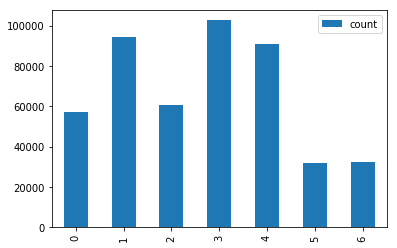

In [33]:
%matplotlib inline 
pandas_df.plot.bar()

### Task 15: (Optional)

Do you have other interesting analytics to do on the log data? Try it below!

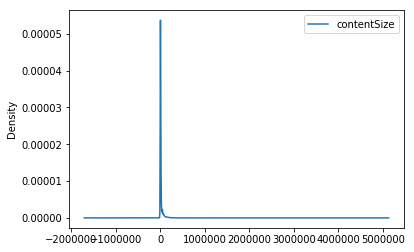

In [34]:
data = access_logs_df.select("contentSize").toPandas()
data.plot.kde()